# Introduction

**I will be implementing a new Deep learning architecture called Vision Transformers using Tensorflow and implementing some basic Image Preprocessing steps to give an insight about how Image processing can be useful in identifying features of importance for Machine Learning and Deep Learning models**

1. [An interesting implementation of Vision Transformer](http://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline/comments#Introduction)

2. [Image processing- Simple guide](https://www.kaggle.com/khotijahs1/image-preprocessing-for-cassava-leaf-disease)

**Big thanks to the implementations of [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) for making the architecture possible** 

**And lastly I will be referring to these implementations so feel free to check them out if you can**

1. [KamalKraj Implementation](https://github.com/kamalkraj/Vision-Transformer)

# Transformer Architecture

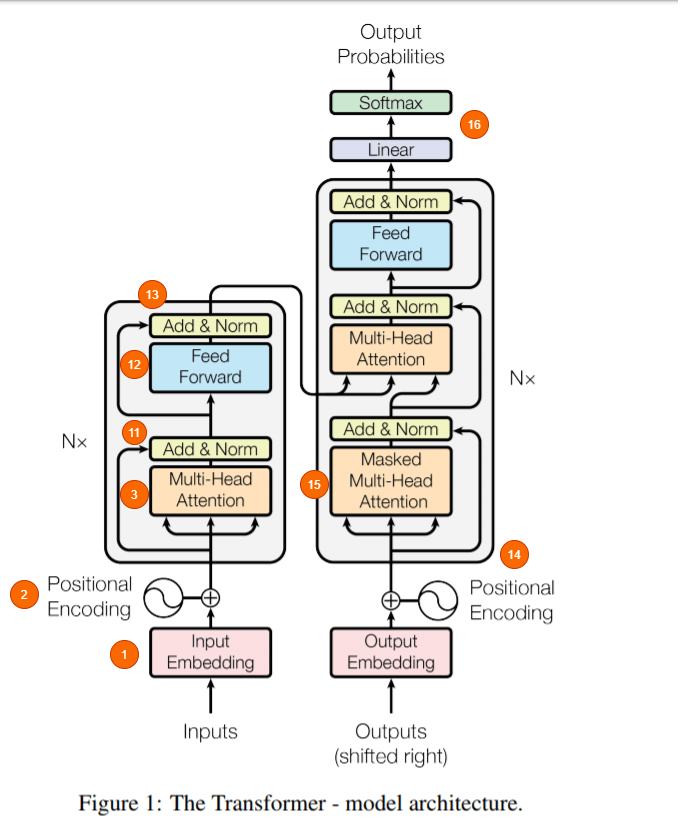

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
import json
import tensorflow as tf
from tensorflow import keras
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the Datasets

**The Casava-leaf Disease classification Dataset contains**

1. **Images data**
2. **CSV format data of train and submission files**
3. **tfrecords of training and test data**
4. **Json file with labels of diseases on images**

In [ ]:
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df.shape

In [ ]:
df.head(5)

In [ ]:
df.info()

**So from this we can infer that the labels are labelled in categorical fashion with particular disease being identified through that, so let's explore the json file for more information**

In [ ]:
#https://www.kaggle.com/khotijahs1/image-preprocessing-for-cassava-leaf-disease

data_dir = '../input/cassava-leaf-disease-classification/'
with open(os.path.join(data_dir,'label_num_to_disease_map.json')) as file:
    map_class = json.loads(file.read())

print(json.dumps(map_class,indent=5))

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['label'].values)
plt.title('Distrbution of Labels in Training data')
plt.show()

**So there is an imbalance in our dataset with majority of labels falling into Cassava Mosaic Disease (CMD) category**

**Now, for better understanding lets put these labels into our training dataset**

In [ ]:
new_df = pd.read_csv(os.path.join(data_dir,"train.csv"))
new_df['class_names'] = df['label'].astype(str).map(map_class)
new_df.head(5)

# Displaying Images with Labels

In [ ]:
def show_image(image_ids, labels):
    plt.figure(figsize=(15,10))
    
    for i, (image_id,label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3,3,i+1)
        img = cv2.imread(os.path.join(data_dir, "train_images", image_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
samples = new_df.sample(9)
image_ids = samples['image_id'].values
labels = samples['class_names'].values

show_image(image_ids, labels)

In [ ]:
#image sizes
images = cv2.imread('../input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
images.shape

# Image Segmentation

In [ ]:
def read_image(image_id , label):
    plt.figure(figsize=(15, 10))
    image = cv2.imread(os.path.join(data_dir, "train_images", image_id))
    #convert image to array
    #img = image.img_to_array(img)
    return image

def create_masks(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])
    
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_image(image):
    mask = create_masks(image)
    output = cv2.bitwise_and(image, image, mask=mask)
    return output/255

In [ ]:
#get an image
image = read_image(df['image_id'][5],(255,255))

#segmentation
image_segmented = segment_image(image)

fig, ax = plt.subplots(1, 2, figsize=(15, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SEGMENTED', fontsize=12)

ax[0].imshow(image/255);
ax[1].imshow(image_segmented);

**Let's visualize next set**

In [ ]:
#get an image
image = read_image(df['image_id'][15],(255,255))

#segmentation
image_segmented = segment_image(image)

fig, ax = plt.subplots(1, 2, figsize=(15, 5));
plt.suptitle('RESULT', x=0.5, y=0.8)
plt.tight_layout(1)

ax[0].set_title('ORIGINAL', fontsize=12)
ax[1].set_title('SEGMENTED', fontsize=12)

ax[0].imshow(image/255);
ax[1].imshow(image_segmented);

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=45, stratify=df.label.values)

print("Training data size : {}".format(train_df.shape))
print("Validation data size : {}".format(valid_df.shape))

# **Image Augmentations**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_directory(directory= data_dir,             
                                                     target_size=(224, 224),
                                                     class_mode='categorical',
                                                     subset='training',
                                                    shuffle=True,
                                                     batch_size=32
                                 )

valid_generator = datagen.flow_from_directory(directory= data_dir,
                                                      target_size=(224, 224),
                                                      subset='validation',
                                                     batch_size=32
                                                    
                                                     )

# Vision Transformers

**While the Transformer architecture has become the de-facto standard for natural language processing tasks, its applications to computer vision remain limited. In vision, attention is either applied in conjunction with convolutional networks, or used to replace certain components of convolutional networks while keeping their overall structure in place. We show that this reliance on CNNs is not necessary and a pure transformer can perform very well on image classification tasks when applied directly to sequences of image patches. When pre-trained on large amounts of data and transferred to multiple recognition benchmarks (ImageNet, CIFAR-100, VTAB, etc), Vision Transformer attains excellent results compared to state-of-the-art convolutional networks while requiring substantially fewer computational resources to train.**

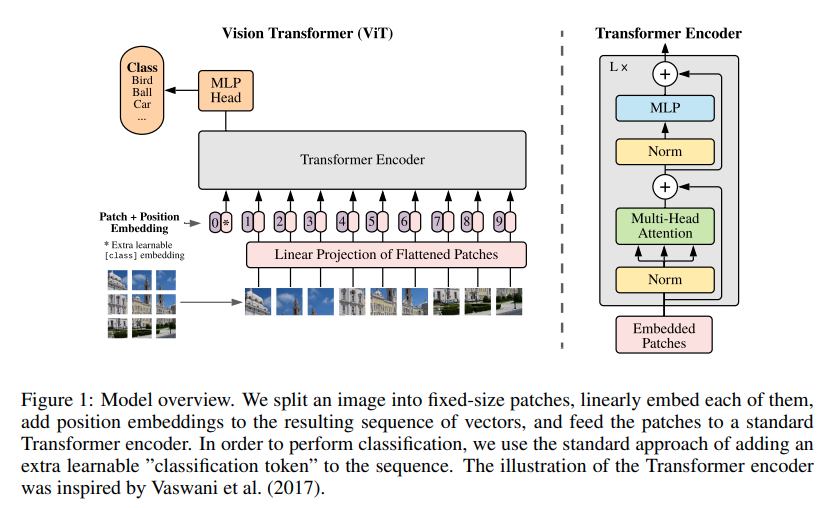

In [ ]:
#importing the neccessary libraries
#https://github.com/emla2805/vision-transformer/blob/master/model.py
import tensorflow_addons as tfa
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    LayerNormalization,
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling



# WORK IN PROGRESS🔨🔨